## Entanglement Distillation

Aus zwei nicht-maximal verschränkten Qubit-Paare wird ein ein verschränktes Qubi-Paar erzeugt, das mit einer bestimmten Wahrscheinlichkeit eine größere Verschränkung aufzeigt.

In [1]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, execute, Aer, IBMQ
from qiskit.circuit import QuantumCircuit,Parameter
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import plot_histogram

#import python stuff
import matplotlib.pyplot as plt
import numpy as np

## Ausgangszustände

In [2]:
backend = Aer.get_backend('qasm_simulator')
phi1 = Parameter('Phi 1')
phi2 = Parameter('Phi 2')

# Dejustierung
phi1_value =  np.pi/4 + 0.1
phi2_value =  np.pi/4 + 0.08
print("|Psi_1> = alpha |0> + beta |1>")
print("alpha   : {:>5f}".format(np.cos(phi1_value)) )
print("beta    : {:>5f}".format(np.sin(phi1_value)) )
print("alpha^2 : {:>5f}".format(np.cos(phi1_value)**2) )
print("beta^2  : {:>5f}".format(np.sin(phi1_value)**2) )
print()
print("|Psi_2> = alpha |0> + beta |1>")
print("alpha   : {:>5f}".format(np.cos(phi2_value)) )
print("beta    : {:>5f}".format(np.sin(phi2_value)) )
print("alpha^2 : {:>5f}".format(np.cos(phi2_value)**2) )
print("beta^2  : {:>5f}".format(np.sin(phi2_value)**2) )

|Psi_1> = alpha |0> + beta |1>
alpha   : 0.632981
beta    : 0.774167
alpha^2 : 0.400665
beta^2  : 0.599335

|Psi_2> = alpha |0> + beta |1>
alpha   : 0.648337
beta    : 0.761353
alpha^2 : 0.420341
beta^2  : 0.579659


In [3]:
# Concurrence
C1 = 2*np.cos(phi1_value)*np.sin(phi1_value)
C2 = 2*np.cos(phi2_value)*np.sin(phi2_value)
print("Concurrence System 1 : {:>5f}".format(C1))
print("Concurrence System 2 : {:>5f}".format(C2))

Concurrence System 1 : 0.980067
Concurrence System 2 : 0.987227


### Analytische Berechnung der Koeffizienten

In [4]:
# Kontrollrechnung

alpha1 = np.cos(phi1_value)
beta1  = np.sin(phi1_value)

alpha2 = np.cos(phi2_value)
beta2  = np.sin(phi2_value)

p00 = (alpha1*alpha2)**2 + (beta1*beta2)**2
p11 = (alpha1*beta2)**2 + (beta1*alpha2)**2

len00 = np.sqrt(p00)
len11 = np.sqrt(p11)


print("p(|00>) : {:>5f}".format(p00) )
print("state after measure |00>:")
print("{:>5f}|00> + {:>5f}|11>".format( alpha1*alpha2/len00, beta1*beta2/len00) )
print("Measurement values")
print(" => {:>5f}".format((alpha1*alpha2)**2) )
print(" => {:>5f}".format((beta1*beta2)**2) )
print("Concurrence : {:>5f}".format(2* alpha1*alpha2/len00*beta1*beta2/len00) )

print("-----------------------------")
print("p(|11>) : {:>5f}".format(p11) )
print("state after measure |11>:")
print("{:>5f}|00> + {:>5f}|11>".format( alpha1*beta2/len11, beta1*alpha2/len11) )
print("Measurement values")
print(" => {:>5f}".format((alpha1*beta2)**2) )
print(" => {:>5f}".format((beta1*alpha2)**2) )
print("Concurrence : {:>5f}".format(2* alpha1*beta2/len11 * beta1*alpha2/len11) )

p(|00>) : 0.515826
state after measure |00>:
0.571400|00> + 0.820672|11>
Measurement values
 => 0.168416
 => 0.347410
Concurrence : 0.937864
-----------------------------
p(|11>) : 0.484174
state after measure |11>:
0.692590|00> + 0.721331|11>
Measurement values
 => 0.232249
 => 0.251925
Concurrence : 0.999174


## Simulation der beiden verschränkten Systeme

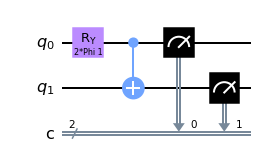

In [5]:
circuit1 = QuantumCircuit(2,2)
circuit1.ry(2*phi1,0)
circuit1.cx(0,1)
circuit1.measure([0,1],[0,1])
circuit1.draw('mpl')

{'11': 6024, '00': 3976}


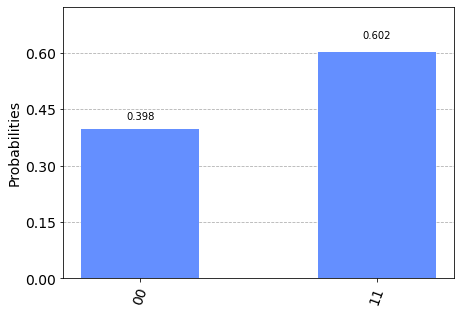

In [6]:
runcircuit1 = circuit1.bind_parameters({phi1: phi1_value })

job = execute(runcircuit1, backend, shots=10000)
result = job.result()
counts = result.get_counts(runcircuit1)
print(counts)
plot_histogram(counts)

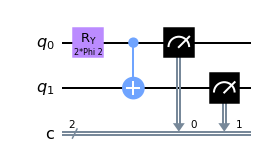

In [7]:
circuit2 = QuantumCircuit(2,2)
circuit2.ry(2*phi2,0)
circuit2.cx(0,1)
circuit2.measure([0,1],[0,1])
circuit2.draw('mpl')

{'00': 4165, '11': 5835}


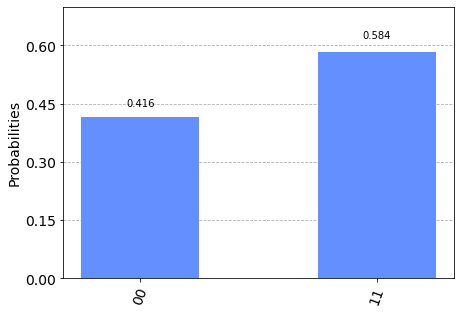

In [8]:
runcircuit2 = circuit2.bind_parameters({phi2: phi2_value })

job = execute(runcircuit2, backend, shots=10000)
result = job.result()
counts = result.get_counts(runcircuit2)
print(counts)
plot_histogram(counts)

## Durchführung der Distillation

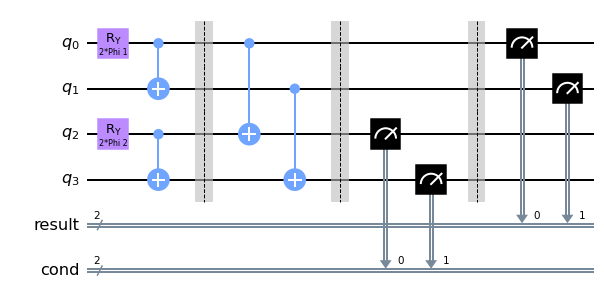

In [9]:
qc = QuantumCircuit()
qr = QuantumRegister(4,'q')
qc.add_register( qr )
crResult = ClassicalRegister(2,'result')
qc.add_register( crResult )
crCond = ClassicalRegister(2,'cond')
qc.add_register( crCond )


qc.ry(2*phi1,0)
qc.cx(0,1)

qc.ry(2*phi2,2)
qc.cx(2,3)

qc.barrier()
qc.cx(0,2)
qc.cx(1,3)

qc.barrier()
qc.measure(qr[2],crCond[0])
qc.measure(qr[3],crCond[1])


qc.barrier()
qc.measure(qr[0],crResult[0])
qc.measure(qr[1],crResult[1])

qc.draw('mpl')

In [10]:
qc = qc.bind_parameters({phi1: phi1_value, phi2: phi2_value })

{'11 00': 4649, '00 11': 6984, '11 11': 5054, '00 00': 3313}


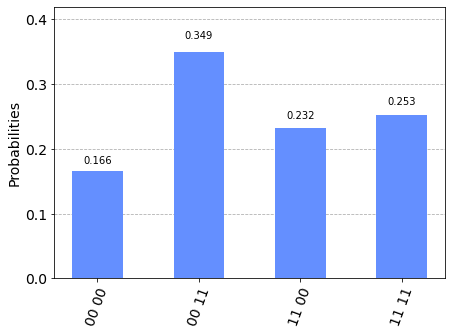

In [11]:
job = execute(qc, backend, shots=20000)
result = job.result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

Erhält man als Messergebis 11, so hat sich die Verschränkung des Qubit-Paars $q_0q_1$ verbessert